# 11 클러스터링
클러스터링은 어떤 데이터들이 주어졌을 때 특성이 비슷한 데이터끼리 묶어 주는 머신 러닝 기법이다. 머신 러닝 알고리즘에 딥러닝을 적용한다면 성능이 더 향상될 수 있다.

## 11.2 클러스터링 알고리즘 유형


### 11.2.1 K-mean 군집화
1. 클러스터 중심인 중심점을 구하기 위해 임의의 점 K를 선택
2. 각 중심에 대한 거리를 계산하여 각 데이터를 가장 가까운 클러스터에 할당
3. 할당된 데이터 평균을 계산하여 새로운 클러스터 중심을 결정
4. 클러스터 할당이 변경되지 않을 때까지 2 ~ 3을 반복

클러스터 개수(K 개수)를 결정하는 것은 쉽지 않다. 이를 결정할 수 있는 방법이 있는데 클러스터 개수와 WCSS(Within Cluster Sum of Squares) 간 관계를 그래프로 표현한 후, WCSS 변경이 평평하게 하락하는 구간을 선택하면 된다

※WCSS
- WCSS는 모든 클러스터에 있는 각 데이터가 중심까지의 거리를 제곱하여 합을 계산하는 방식으로 합을 최소화하는 것이 가장 이상적
- 하지만 데이터들이 중심 값이 되어 거리가 0이 되면 이상적으로 보이지만 이는 관측치만큼 많은 클러스터를 가지고 있기 때문에 의미 없는 값이 된다. 이를 해결하기 위해 엘보 그래프(elbow graph)를 사용
- 엘보 그래프: K 값 범위에 대하 K-평균 알고리즘을 무작위로 초기화하고, 각 K 값을 WCSS에 플로팅한다.



In [ ]:
#11.2.1 K-Means

In [2]:
!pip install kmeans_pytorch
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from kmeans_pytorch import kmeans, kmeans_predict
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/deel_learning_pytorch_book/deep learning pytorch book/11장/data/iris.csv')
# iris dataset, https://www.kaggle.com/saurabh00007/iriscsv?select=Iris.csv
# iris dataset은 꽃잎의 너비와 길이 등을 측정한 데이터이고 150개의 레코드로 구성되어 있다
df.info() # Species의 경우 Dtype이 object이기 때문에 나중에 flaot64로 바꿔줄 예정
# object 데이터 타입을 갖는 Species 칼럼은 숫자가 아닌 단어로 구성되어 있음
# 단어는 꽃잎의 너비와 길이에 따라 붓꽃의 세 가지 범주를 나타낸다
print('------------------------------------------')
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
------------------------------------------
      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...           

In [5]:
data=pd.get_dummies(df, columns=['Species']) # 단어를 숫자로 바꾸는 워드 임베딩 진행
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,1,5.1,3.5,1.4,0.2,1,0,0
1,2,4.9,3.0,1.4,0.2,1,0,0
2,3,4.7,3.2,1.3,0.2,1,0,0
3,4,4.6,3.1,1.5,0.2,1,0,0
4,5,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,0,0,1
146,147,6.3,2.5,5.0,1.9,0,0,1
147,148,6.5,3.0,5.2,2.0,0,0,1
148,149,6.2,3.4,5.4,2.3,0,0,1


In [6]:
from sklearn.model_selection import train_test_split
x, y = train_test_split(data, test_size=0.2, random_state=123) # train, test dataset split

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # data의 각 column마다 수의 범위가 다르기 때문에 표준화를 진행(평균 0, 표준편차 1)
X_scaled = scaler.fit(data).transform(x) # fit(data)는 data의 표준편차를 게산, transform은 계산된 평균과 표준편차를 적용하는 함수
y_scaled = scaler.fit(y).transform(y)

In [9]:
x = torch.from_numpy(X_scaled)
y = torch.from_numpy(y_scaled)

In [10]:
print(x.size()) # train dataset size
print(y.size()) # test dataset size
print(x)

torch.Size([120, 8])
torch.Size([30, 8])
tensor([[ 1.2817e+00,  1.8862e+00, -5.8776e-01,  1.3314e+00,  9.2206e-01,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [ 1.0277e+00,  1.8983e-01, -1.9762e+00,  7.0589e-01,  3.9617e-01,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [-1.0508e+00, -1.3854e+00,  3.3785e-01, -1.2275e+00, -1.3130e+00,
          1.4142e+00, -7.0711e-01, -7.0711e-01],
        [-1.7205e+00, -9.0068e-01,  1.0321e+00, -1.3413e+00, -1.3130e+00,
          1.4142e+00, -7.0711e-01, -7.0711e-01],
        [-2.8868e-01,  1.8983e-01, -1.9762e+00,  1.3724e-01, -2.6119e-01,
         -7.0711e-01,  1.4142e+00, -7.0711e-01],
        [ 4.2725e-01, -1.0218e+00, -1.7448e+00, -2.6082e-01, -2.6119e-01,
         -7.0711e-01,  1.4142e+00, -7.0711e-01],
        [ 1.3048e+00,  2.4920e+00,  1.7263e+00,  1.5020e+00,  1.0535e+00,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [-1.6051e+00, -5.3718e-01,  1.9577e+00, -1.1707e+00, -1.0500e+00,
          1.4142e+00, -7

In [13]:
num_clusters = 3 # iris dataset에서 class의 종류가 3가지니까
cluster_ids_x, cluster_centers = kmeans(
    X=x, num_clusters=num_clusters, distance='euclidean', device=device
)
# X: train dataest
# num_clusters: cluster 개수
# distance: 클러스터를 구성하기 위해 데이터 간의 거리를 계산하는 방법. 
# 데이터 간 유사도를 측정하는 방법으로 유클리드 거리, 맨해튼 거리, 민코프스키 거리, 코사인 유사도 등 존재
# 해당 함수의 실행 결과는 train result를 보여준다
# center_shift: 유클리드 거리 계산을 이용해 반복적으로 클러스터 중심을 변경하는데 
# 이 과정은 더 이상 중심을 옮길 필요가 없을 때까지 반복되며 'iteration' 파라미터에 의해 최종 반복 횟수가 출력된다
# iteration: tol을 만족하면 학습을 멈추고 반복 횟수를 출력
# tol: tolerance의 약자로 학습을 중지할 기준이 되는 값

running k-means on cuda..


[running kmeans]: 7it [00:00, 75.81it/s, center_shift=0.000000, iteration=7, tol=0.000100]


In [18]:
print(cluster_ids_x, cluster_ids_x.shape) # cluster에 대한 ID 정보를 출력(여기선 num_cluster = 3이니까 0, 1, 2로 이루어짐)
print(cluster_centers) # cluster 중심에서부터의 거리를 나타낸다

tensor([2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1,
        2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2,
        2, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2]) torch.Size([120])
tensor([[-1.1894, -0.7225,  1.6310, -1.3011, -1.1815,  1.4142, -0.7071, -0.7071],
        [-1.1813, -1.2400,  0.2337, -1.3043, -1.2867,  1.4142, -0.7071, -0.7071],
        [ 0.5374,  0.4920, -0.4344,  0.6319,  0.5989, -0.7071,  0.4174,  0.2897]])


In [19]:
cluster_ids_y = kmeans_predict(
    y, cluster_centers, 'euclidean', device=device
) # test dataset에 학습을 통해 구한 cluster 중심을 사용해 clustering 적용. 예측을 위해 kmeans_predict를 사용

predicting on cuda..


In [20]:
print(cluster_ids_y)

tensor([2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2,
        0, 0, 0, 2, 2, 0])


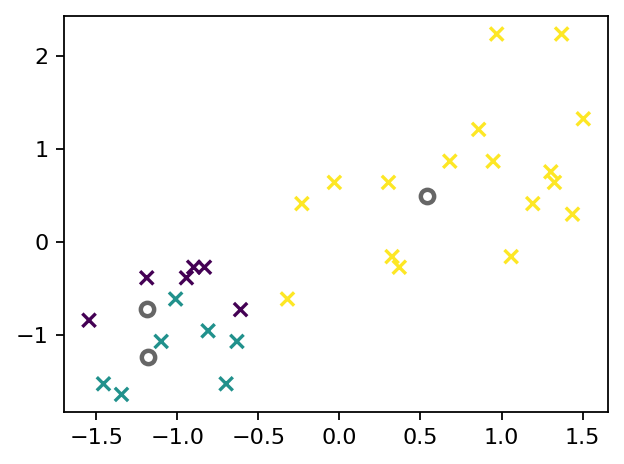

In [22]:
plt.figure(figsize=(4, 3), dpi=160)
plt.scatter(y[:, 0], y[:, 1],c=cluster_ids_y, cmap='viridis', marker='x') # test dataset에 cluster 적용된 그래프 그리기

plt.scatter( # cluster center
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)

plt.tight_layout()
plt.show()

### 11.2.2 가우시안 혼합 모델(Gaussian Mixture Model)
- 가우시안 분포가 여러 개 혼합된 클러스터링 알고리즘
- 현실에 있는 복잡한 형태의 확률 분포를 가우시안분포 K개를 혼합해 표현하는 방식(K는 hyperparameter)
- 주어진 데이터에 대해 이 데이터가 어떤 가우시안 분포에 속하는지 찾는 방식
- 데이터가 주어지고 K개의 가우시안 분포 중 가장 높은 값의 가우시안 분포를 찾는 방식

In [ ]:
#11.2.2 Gaussian Mixture Model

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
X_train = np.load('/content/drive/MyDrive/deel_learning_pytorch_book/deep learning pytorch book/11장/data/data.npy') # numpy 배열 파일 load

[[1.60629419 1.3470999 ]
 [3.0363831  3.09828041]]


[[[ 0.75275611 -0.5054196 ]
  [-0.5054196   0.74286061]]

 [[ 0.8465178   0.38644336]
  [ 0.38644336  0.73395863]]]


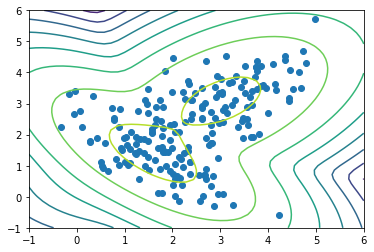

In [24]:
gmm = GaussianMixture(n_components=2) # n_components 는 가우시안 개수를 의미. 이 경우 2개의 가우시안 분포를 겹쳐보이게 그림
gmm.fit(X_train)

print(gmm.means_)
print('\n')
print(gmm.covariances_)

X, Y = np.meshgrid(np.linspace(-1, 6), np.linspace(-1,6)) # -1 ~ 6 사이의 X와 Y 좌표에 데이터를 플로팅한다다
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape((50,50))

plt.contour(X, Y, Z)
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.show()
# 노란색 타원이 평균을 의미하고 이 타원 근처에 대부분의 데이터가 존재하는 것을 볼 수 있다.

### 11.2.3 자기 조직화 지도(Self-Organizing Map, SOM)
- 신경 생리학적 시스템을 모델링한 것으로 입력 패턴에 대해 정확한 정답을 주지 않고 스스로 학습을 해 클러스터링하는 알고리즘
- SOM은 입력층과 경쟁층(2차원 격자)으로 연결되어 있음
- 가중치는 연결 강도를 나타내며 0 ~ 1 사이의 정규화된 값을 사용
- 학습 순서는 네 단계로 진행
  1. 초기화(initialization): 모든 연결 가중치는 작은 임의의 값으로 초기화
  2. 경쟁(competition): 자기 조직화 지도는 경쟁 학습(competive learning)을 이용해 입력층과 경쟁층을 연결한다. 연결 강도 벡터가 입력 벡터와 얼마나 가까운지 계산하여 가장 가까운 뉴런이 승리하는 '승자 독점(winner take all)' 방식
  3. 협력(cooperation): 승자 뉴런은 네트워크에서 가장 좋은 공간 위치를 차지하게 되며, 승자와 함께 학습할 이웃 크기를 정의
  4. 적응(adaption): 슬리한 뉴런의 가중치와 이웃 뉴런을 업데이트한다. 그리고 최종적으로 원하는 횟수만큰 2~3의 과정을 반복

In [ ]:
#11.2.3 자기조직화 지도 (Self-Organizing Map, SOM)

In [26]:
!pip install minisom
import numpy as np
from sklearn.datasets import load_digits
from minisom import MiniSom  
from pylab import plot,axis,show,pcolor,colorbar,bone

digits = load_digits() # 숫자 필기 dataset load
data = digits.data # train dataset
labels = digits.target # label

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9016 sha256=01c34e9711d9aa576b3d8ed95520e806125dbe84d24e8c6f9ff2c16bc26fc2cf
  Stored in directory: /root/.cache/pip/wheels/6d/4e/9e/a95c14a232a196c22d9c04b221ff5d25461a1a4c55339c61db
Successfully built minisom


SOM 초기화.

. SOM 진행 종료


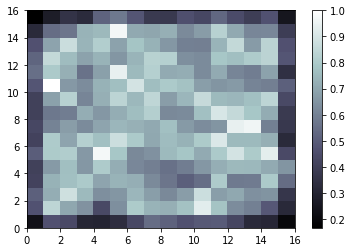

In [27]:
som = MiniSom(16,16,64,sigma=1.0,learning_rate=0.5) # 시각화 기능이 거의 없는 SOM을 구현할 수 있는 라이브러리
# 순서대로 X축에 대한 차원, y축에 대한 차원, input vector 개수, sigma: 이웃 노드와의 인접 반경
som.random_weights_init(data)
print("SOM 초기화.")
som.train_random(data,10000) 
print("\n. SOM 진행 종료")

bone()
pcolor(som.distance_map().T) 
colorbar()

<ipython-input-28-13c5c0ff45e4>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[labels == '0'] = 0
<ipython-input-28-13c5c0ff45e4>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[labels == '1'] = 1
<ipython-input-28-13c5c0ff45e4>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[labels == '2'] = 2
<ipython-input-28-13c5c0ff45e4>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[labels == '3'] = 3
<ipython-input-28-13c5c0ff45e4>:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels[labels == '4'] = 4
<ipython-input-28-13c5c0ff45e4>:6: FutureWarning: eleme

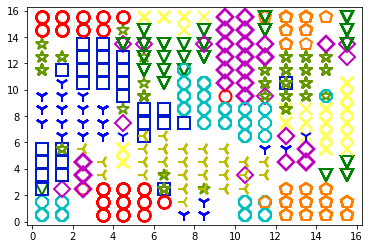

In [28]:
labels[labels == '0'] = 0
labels[labels == '1'] = 1
labels[labels == '2'] = 2
labels[labels == '3'] = 3
labels[labels == '4'] = 4
labels[labels == '5'] = 5
labels[labels == '6'] = 6
labels[labels == '7'] = 7
labels[labels == '8'] = 8
labels[labels == '9'] = 9
# 위는 label 설정
markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', '*']
colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]
for cnt,xx in enumerate(data):
   w = som.winner(xx)  # 승자 식별
   plot(w[0]+.5,w[1]+.5,markers[labels[cnt]],    
   markerfacecolor='None', markeredgecolor=colors[labels[cnt]], 
   markersize=12, markeredgewidth=2)
show()